# Statistical Inference on the Composition of Red Wine
Group: 44

Members: Anthony Leong, Arav Dewan, Nikita Prabhu, Xiaomeng Zhou

## Introduction

As a commodity to be consumed, the quality of wine is of great importance, though it can differ greatly from wine to wine. A possible factor that influences the quality of a wine is its composition, so this study will aim to use statistical inference to determine if there is a significant difference between the compositions of different quality wines.

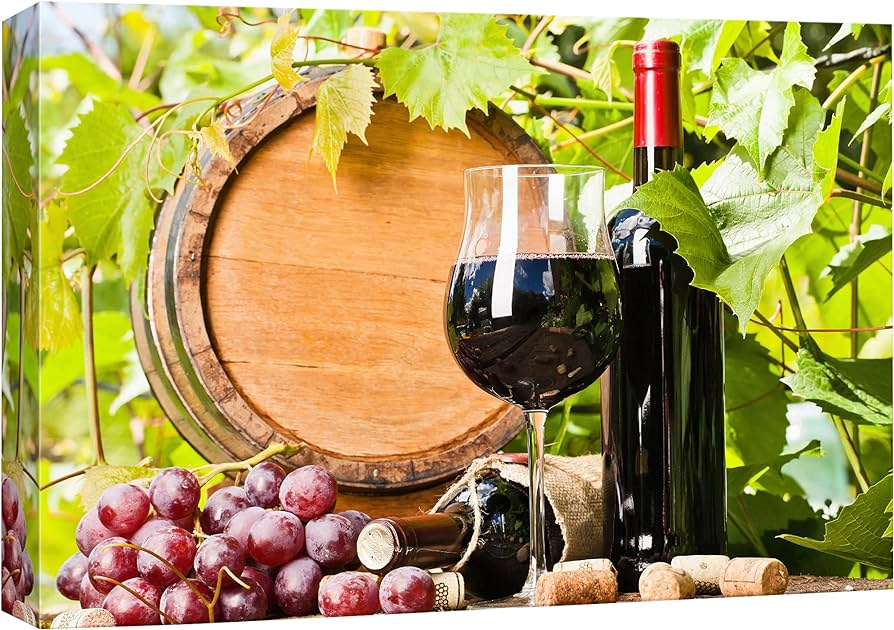

The dataset used is the [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality) dataset from the UCI machine learning repository, and it consists of red and white variants of *vinho verde* wine. For this study, we will only be using red wine and we will classify each wine as either "low" or "high" quality.

Wine quality is linked to what is referred to as the sugar-acid balance, so understanding how the acidity of a wine affects its quality is of significant importance (White, 2019). Therefore, the variables of interest are:

**Fixed Acidity:** A major wine constituent, contributing greatly to its taste, imparting the sourness or tartness that is a fundamental feature in wine taste.

**Volatile Acidity:** The steam distillable acids present in wine, primarily acetic acid but also lactic, formic, butyric, and propionic acids, imparting a vinegar-like taste.

And the research question being answered in this study is:

**Do fixed acidity and volatile acidity differ between different qualities of red wine?**

## Methods and Results

### Preliminary Analysis

In [1]:
# Loading necessary packages
library(cowplot)
library(digest)
library(infer)
library(repr)
library(tidyverse)
library(datateachr)
library(gridExtra)
#install.packages("corrplot")
#library(corrplot)
library(broom)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# Reading dataset
options(repr.matrix.max.rows = 8)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
raw_wine_data <- read_delim(url, skip = 1, delim = ";",
                            col_names = c("fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar",
                                          "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide",
                                          "density", "pH", "sulphates", "alcohol", "quality"))
head(raw_wine_data)

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


Table 1: Raw dataset of red wines.

There are many possible ways to classify each wine as either "low" or "high" quality, but for this study, we will use the mean of quality as the cutoff between “low” and “high” quality.

To achieve this, we will divide the raw dataset into two smaller datasets. Wines that have a quality score that is below the mean of the raw dataset will be stored in the `low_quality` data frame, and wines that have a quality score that is above the mean of the raw dataset will be stored in the `high_quality` data frame. Additionally, each wine in the `low_quality` data frame will have its quality score converted to "LOW" and each wine in the `high_quality` data frame will have its quality score converted to "HIGH". The `low_quality` and `high_quality` data frames are then recombined as the `wine_data` data frame.

In [3]:
# Converting quality to "HIGH" or "LOW"
mean_quality <- raw_wine_data |>
    summarize(mean_quality = mean(quality)) |>
    pull()

low_quality <- raw_wine_data |>
    filter(quality <= mean_quality) |>
    mutate(quality = "LOW")

high_quality <- raw_wine_data |>
    filter(quality > mean_quality) |>
    mutate(quality = "HIGH")

wine_data <- bind_rows(low_quality, high_quality)
head(wine_data)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,LOW
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,LOW
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,LOW
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,LOW
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,LOW
7.9,0.60,0.06,1.6,0.069,15,59,0.9964,3.30,0.46,9.4,LOW


Table 2: Dataset of red wines, classified as either "HIGH" or "LOW" quality.

Now that each wine has been classified, we can compute summary statistics to estimate various parameters across each category of wine quality. We can also visualize the distributions of our two variables of interest across the two categories of wine quality.

In [4]:
# Calculate summary statistics

low_n <- nrow(low_quality)
low_fixed_mean <- mean(low_quality$fixed_acidity)
low_fixed_sd <- sd(low_quality$fixed_acidity)
low_volatile_mean <- mean(low_quality$volatile_acidity)
low_volatile_sd <- sd(low_quality$volatile_acidity)
high_n <- nrow(high_quality)
high_fixed_mean <- mean(high_quality$fixed_acidity)
high_fixed_sd <- sd(high_quality$fixed_acidity)
high_volatile_mean <- mean(high_quality$volatile_acidity)
high_volatile_sd <- sd(high_quality$volatile_acidity)

summary_stats <- tibble(Quality = c("LOW", "HIGH"),
                        n = c(low_n, high_n),
                        "Fixed Acidity Mean" = c(low_fixed_mean, high_fixed_mean),
                        "Fixed Acidity SD" = c(low_fixed_sd, high_fixed_sd),
                        "Volatile Acidity Mean" = c(low_volatile_mean, high_volatile_mean),
                        "Volatile Acidity SD" = c(low_volatile_sd, high_volatile_sd))
summary_stats

Quality,n,Fixed Acidity Mean,Fixed Acidity SD,Volatile Acidity Mean,Volatile Acidity SD
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
LOW,744,8.142204,1.572396,0.5895027,0.1779562
HIGH,855,8.474035,1.862795,0.4741462,0.1619993


Table 3: Table of summary statistics.

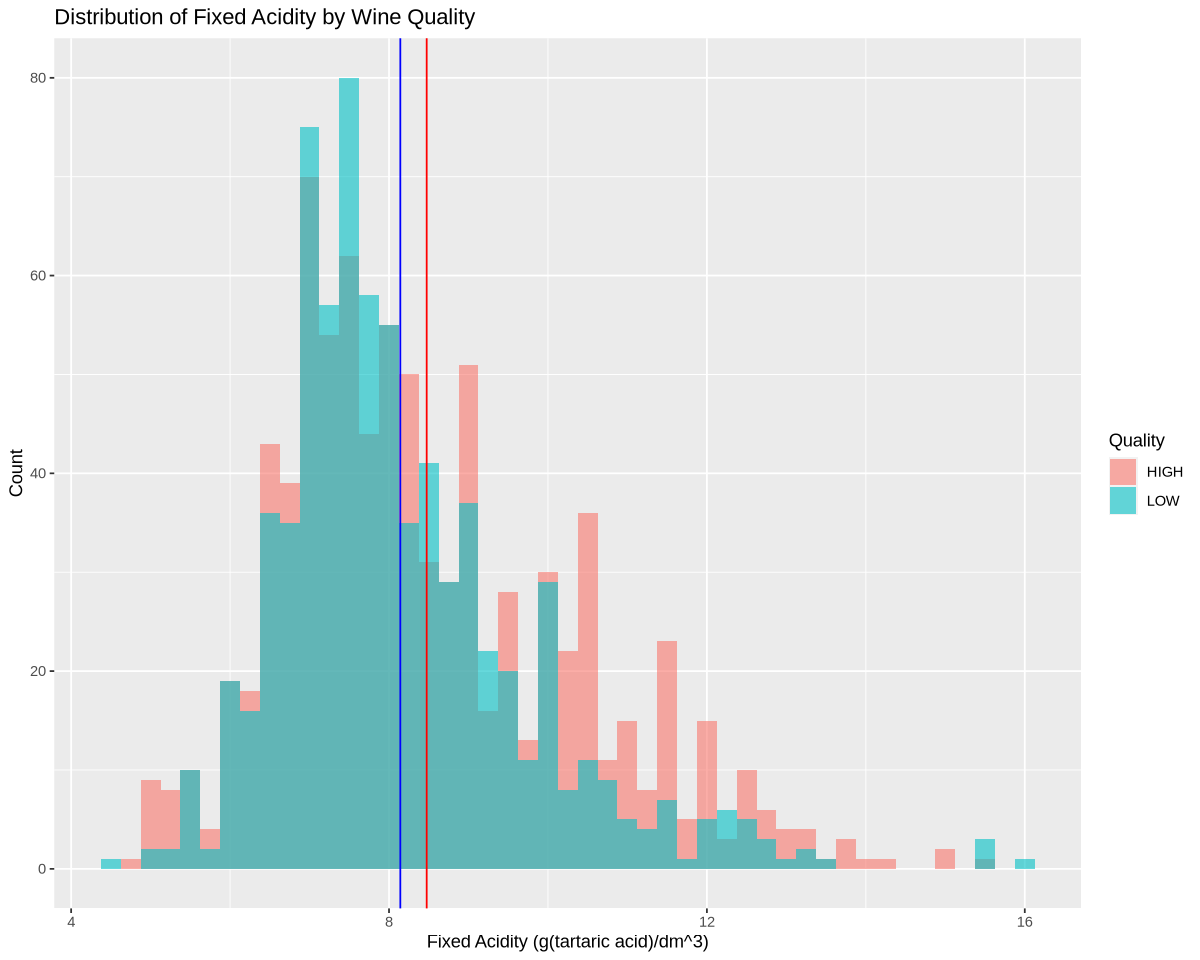

In [5]:
# Visualizing the distribution of fixed acidity by wine quality
options(repr.plot.width = 10, repr.plot.height = 8)

fixed_plot <- wine_data |>
    ggplot(aes(x = fixed_acidity, fill = quality)) +
    geom_histogram(alpha = 0.6, position = "identity", binwidth = 0.25) +
    geom_vline(xintercept = 8.474035, color = "red") +
    geom_vline(xintercept = 8.142204, color = "blue") +
    labs(x = "Fixed Acidity (g(tartaric acid)/dm^3)",
         y = "Count",
         title = "Distribution of Fixed Acidity by Wine Quality",
         fill = "Quality")
fixed_plot

Figure 1: Histogram comparing the distribution of `fixed_acidity` between different wine qualities. The blue line is the mean of `fixed_acidity` for low quality wines, and the red line is the mean of `fixed_acidity` for high quality wines.

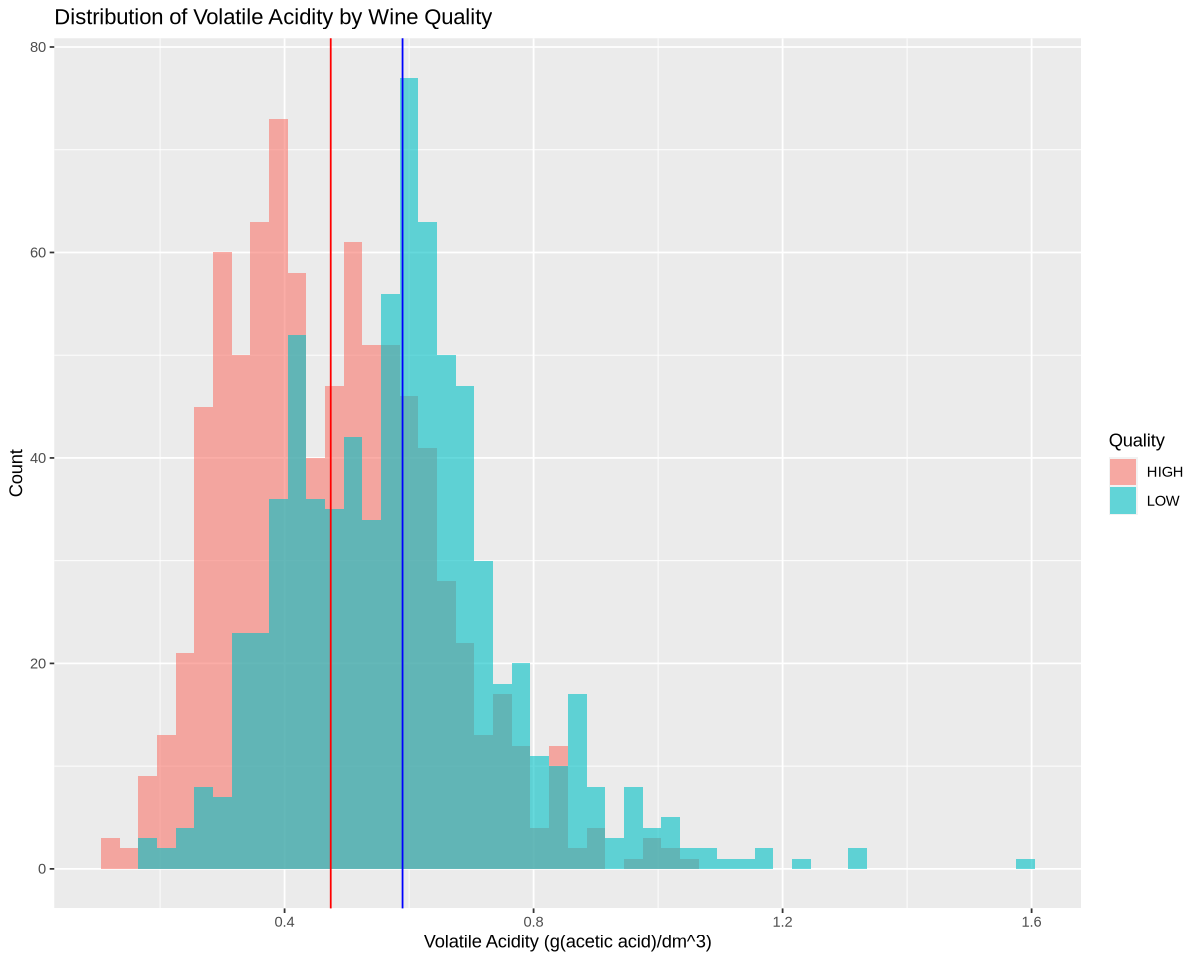

In [6]:
# Visualizing the distribution of volatile acidity by wine quality
options(repr.plot.width = 10, repr.plot.height = 8)

volatile_plot <- wine_data |>
    ggplot(aes(x = volatile_acidity, fill = quality)) +
    geom_histogram(alpha = 0.6, position = "identity", binwidth = 0.03) +
    geom_vline(xintercept = 0.4741462, color = "red") +
    geom_vline(xintercept = 0.5895027, color = "blue") +
    labs(x = "Volatile Acidity (g(acetic acid)/dm^3)",
         y = "Count",
         title = "Distribution of Volatile Acidity by Wine Quality",
         fill = "Quality")
volatile_plot

Figure 2: Histogram comparing the distribution of `volatile_acidity` between different wine qualities. The blue line is the mean of `volatile_acidity` for low quality wines, and the red line is the mean of `volatile_acidity` for high quality wines.

The mean of `fixed_acidity` for low quality wine is 8.142204 and 8.474035 for high quality wine, both in g(tartaric acid)/dm^3. Looking at Figure 1, it is unclear if the difference between these two statistics is significant, given that the sample sizes are quite large.

The mean of `volatile_acidity` for low quality wine is 0.5895027 and 0.4741462 for high quality wine, both in g(acetic acid)/dm^3. Looking at Figure 2, there seems to be a significant difference between these two statistics.

Regardless of our initial findings, we will still have to use rigorous statistical inference methods to compare the means of `fixed_acidity` and `volatile_acidity` between high and low quality red wine, as the results of these methods may differ from what we can interpret from the histograms.

### Constructing Confidence Intervals Through Bootstrapping

We will start by constructing 90% confidence intervals to determine plausible ranges for our parameters of interest, the mean difference of `fixed_acidity` between high and low quality wine, and the mean difference of `volatile_acidity` between high and low quality wines. The reason why we chose 90% for our confidence level will be explained later on in this report.

In [7]:
# Generating a bootstrap distribution of mean difference in fixed acidity
set.seed(123)
fixed_bootstrap_dist <- wine_data |>
    specify(fixed_acidity ~ quality) |>
    generate(reps = 1000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("HIGH", "LOW"))

# Calculating 90% confidence interval for mean difference in fixed acidity
fixed_boostrap_ci <- fixed_bootstrap_dist |>
    get_ci(level = 0.9, type = "percentile")

# Generating a bootstrap distribution of mean difference in volatile acidity
set.seed(123)
volatile_bootstrap_dist <- wine_data |>
    specify(volatile_acidity ~ quality) |>
    generate(reps = 1000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("HIGH", "LOW"))

# Calculating 90% confidence interval for mean difference in volatile acidity
volatile_boostrap_ci <- volatile_bootstrap_dist |>
    get_ci(level = 0.9, type = "percentile")

# Combining both 90% confidence intervals into a single data frame
bootstrap_ci <- bind_rows(fixed_boostrap_ci, volatile_boostrap_ci) |>
    mutate(Response = c("Fixed Acidity", "Volatile Acidity"),
           "Bootstrap Lower CI" = lower_ci,
           "Bootstrap Upper CI" = upper_ci) |>
    select(!c(1,2))
bootstrap_ci

Response,Bootstrap Lower CI,Bootstrap Upper CI
<chr>,<dbl>,<dbl>
Fixed Acidity,0.1950176,0.4737029
Volatile Acidity,-0.1286175,-0.1011156


Table 4: Confidence intervals obtained from bootstrapping. "CI" is an abbreviation of "confidence interval".

### Constructing Confidence Intervals Using the Central Limit Theorem

Alternatively, the Central Limit Theorem (CLT) can be used instead of bootstrapping to construct confidence intervals. From Table 3, we know that the sample size of high quality wines is 855 and the sample size of low quality wines is 744. Both sample sizes are more than enough to be considered sufficiently large for the CLT to be applicable.

In [8]:
# Using CLT to calculate 90% confidence interval for mean difference in fixed acidity
fixed_clt_ci <- tibble(lower_ci = high_fixed_mean - low_fixed_mean + qnorm(0.05) * sqrt(high_fixed_sd ** 2 / high_n + low_fixed_sd ** 2 / low_n),
                       upper_ci = high_fixed_mean - low_fixed_mean + qnorm(0.95) * sqrt(high_fixed_sd ** 2 / high_n + low_fixed_sd ** 2 / low_n))

# Using CLT to calculate 90% confidence interval for mean difference in volatile acidity
volatile_clt_ci <- tibble(lower_ci = high_volatile_mean - low_volatile_mean + qnorm(0.05) * sqrt(high_volatile_sd ** 2 / high_n + low_volatile_sd ** 2 / low_n),
                          upper_ci = high_volatile_mean - low_volatile_mean + qnorm(0.95) * sqrt(high_volatile_sd ** 2 / high_n + low_volatile_sd ** 2 / low_n))

# Combining both 90% confidence intervals into a single data frame
clt_ci <- bind_rows(fixed_clt_ci, volatile_clt_ci) |>
    mutate(Response = c("Fixed Acidity", "Volatile Acidity"),
           "CLT Lower CI" = lower_ci,
           "CLT Upper CI" = upper_ci) |>
    select(!c(1,2))
clt_ci

Response,CLT Lower CI,CLT Upper CI
<chr>,<dbl>,<dbl>
Fixed Acidity,0.1905108,0.4731508
Volatile Acidity,-0.1294351,-0.1012779


Table 5: Confidence intervals obtained from applying the Central Limit Theorem.

### Visualizing and Comparing Confidence Intervals

Using `visualize()`, we can visualize and compare the two confidence intervals we calculated.

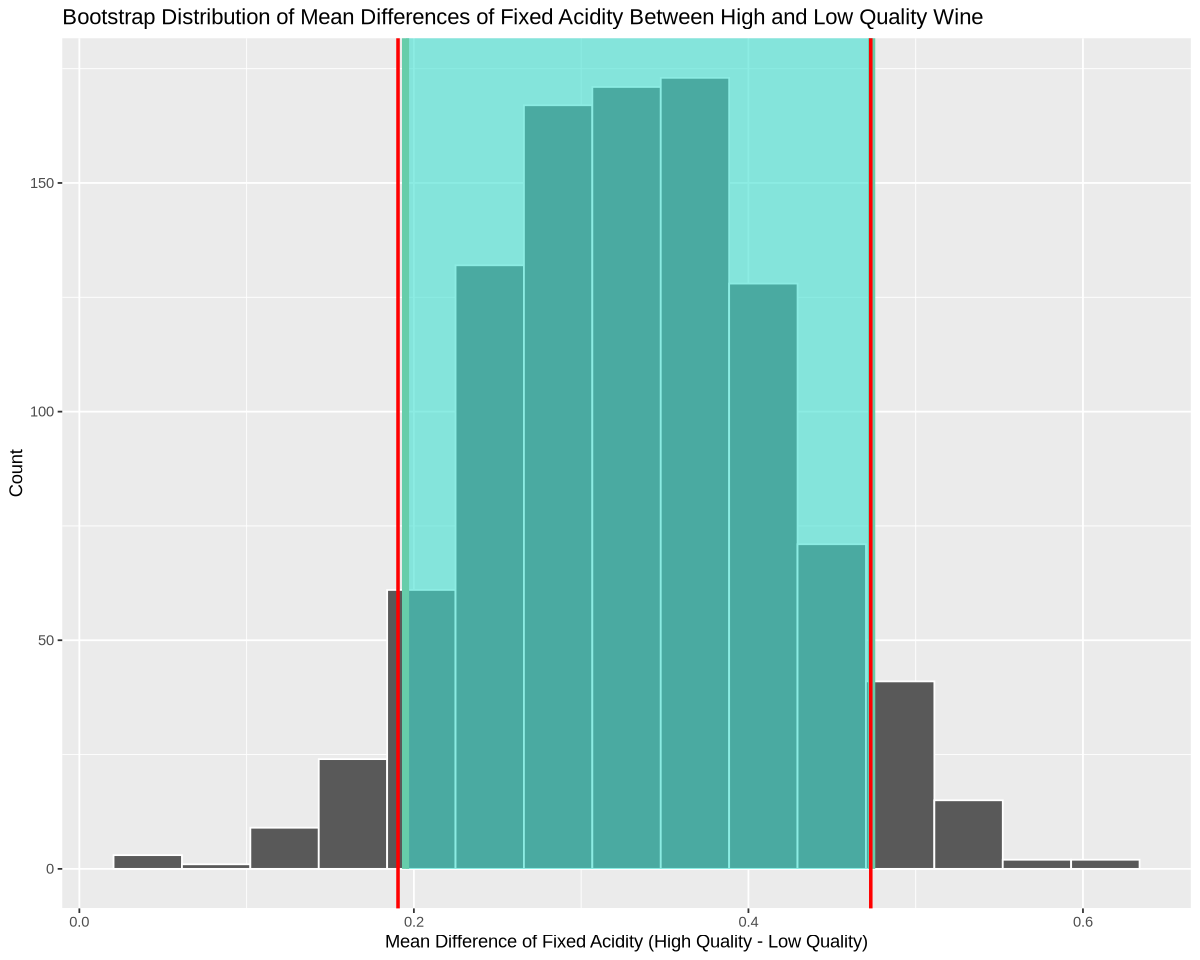

In [9]:
# Visualizing the confidence interval for mean difference of fixed acidity
options(repr.plot.width=10,repr.plot.height=8)
fixed_bootstrap_plot <- fixed_bootstrap_dist |>
    visualize() + 
    shade_ci(endpoints = fixed_boostrap_ci) +
    geom_vline(data = fixed_clt_ci, aes(xintercept=lower_ci), color="red", lwd = 1) +
    geom_vline(data = fixed_clt_ci, aes(xintercept=upper_ci), color="red", lwd = 1) +
    labs(x = "Mean Difference of Fixed Acidity (High Quality - Low Quality)",
         y = "Count",
         title = "Bootstrap Distribution of Mean Differences of Fixed Acidity Between High and Low Quality Wine")

fixed_bootstrap_plot

Figure 3: Histogram of the bootstrap distribution of mean differences of fixed acidity. The cyan area is the confidence interval obtained from bootstrapping. The red lines are the endpoints of the confidence interval obtained from applying the CLT.

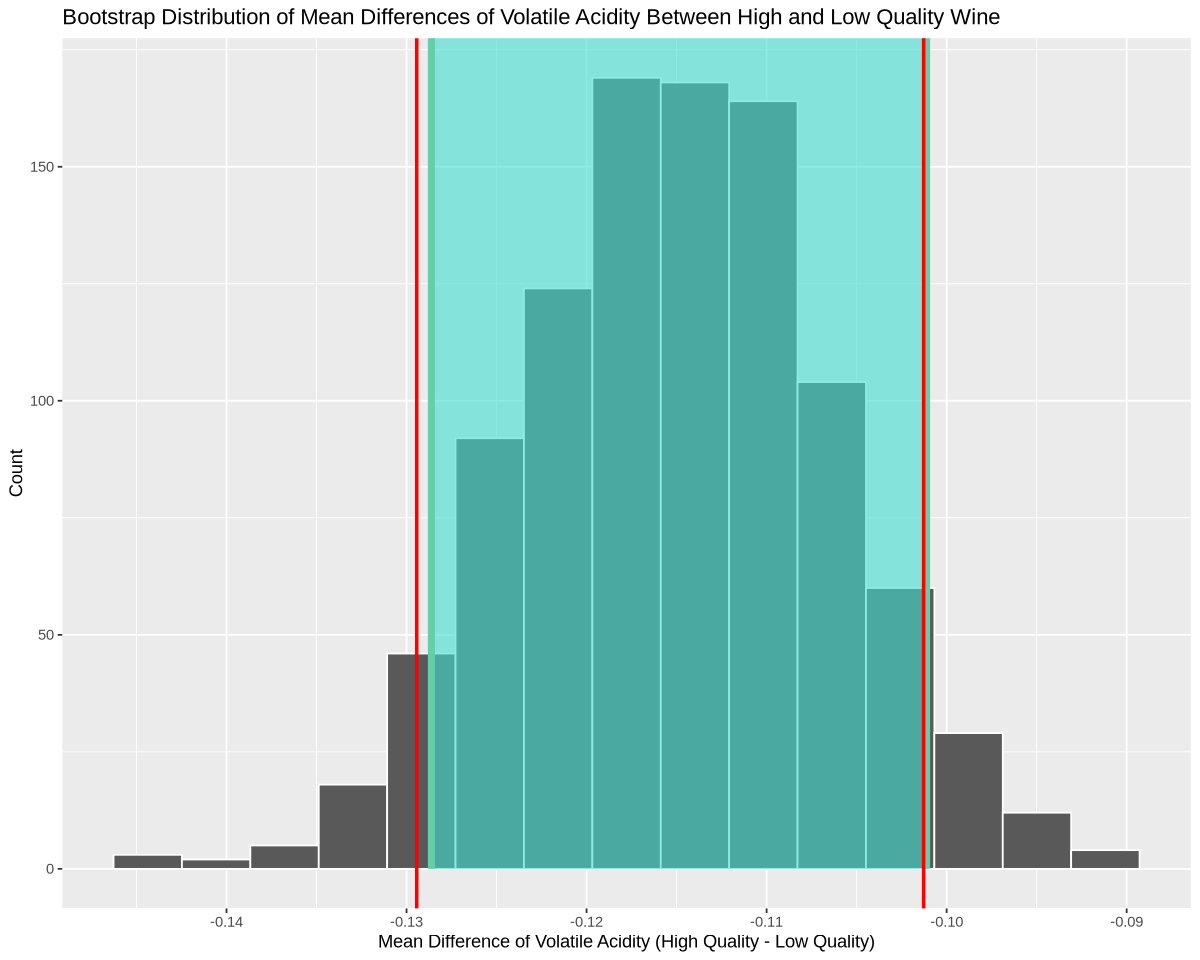

In [10]:
# Visualizing the confidence interval for mean difference of volatile acidity
options(repr.plot.width=10,repr.plot.height=8)
volatile_bootstrap_plot <- volatile_bootstrap_dist |>
    visualize() + 
    shade_ci(endpoints = volatile_boostrap_ci) +
    geom_vline(data = volatile_clt_ci, aes(xintercept=lower_ci), color="red", lwd = 1) +
    geom_vline(data = volatile_clt_ci, aes(xintercept=upper_ci), color="red", lwd = 1) +
    labs(x = "Mean Difference of Volatile Acidity (High Quality - Low Quality)",
         y = "Count",
         title = "Bootstrap Distribution of Mean Differences of Volatile Acidity Between High and Low Quality Wine")
volatile_bootstrap_plot

Figure 4: Histogram of the bootstrap distribution of mean differences of volatile acidity. The cyan area is the confidence interval obtained from bootstrapping. The red lines are the endpoints of the confidence interval obtained from applying the CLT.

As we can see from Figure 3 and Figure 4, the confidence intervals obtained from the bootstrapping method and the CLT method are very similar. A deeper comparison of the results of these two methods will be performed later in this study.

### Hypothesis Testing

We will conduct hypothesis testing to determine if the mean differences we observed are a real effect in the data and not just a product of sampling variation. To start, we will have to define our hypothesis tests. Let $\mu_{fh}$, $\mu_{fl}$, $\mu_{vh}$, and $\mu_{vl}$ be defined as follows:

- $\mu_{fh}$ represents the population mean of `fixed_acidity` for "high" quality wines
- $\mu_{fl}$ represents the population mean of `fixed_acidity` for "low" quality wines
- $\mu_{vh}$ represents the population mean of `volatile_acidity` for "high" quality wines
- $\mu_{vl}$ represents the population mean of `volatile_acidity` for "low" quality wines

Using these symbols, we can define our hypothesis tests as:

Hypothesis tests 1: \
$H_0$: $\mu_{fh} - \mu_{fl} = 0$\
$H_1$: $\mu_{fh} - \mu_{fl} \neq 0$

Hypothesis tests 2: \
$H_0$: $\mu_{vh} - \mu_{vl} = 0$\
$H_1$: $\mu_{vh} - \mu_{vl} \neq 0$

This report is more concerned about determining whether fixed acidity and volatile acidity differ between qualities of red wine. If there is a difference, either in fixed acidity, volatile acidity, or both, that is a sign that a deeper and more comprehensive study should be conducted to research the relationship between acidity and wine quality. Therefore, for both hypothesis tests, we will use a fairly liberal $\alpha = 0.1$ as our significance level. Choosing $\alpha = 0.1$ means we will have to use 90% as our confidence level (as seen previously).

### Hypothesis Testing via Simulation

The first method we will use to conduct our hypothesis tests is simulating the null distribution via bootstrapping. We obtain the null distribution by using the `infer` functions `specify()`, `hypothesize()`, `generate()`, `and calculate()`.

In [11]:
# Calculating observed mean difference of fixed acidity
obs_fixed_diff <- wine_data |>
    specify(fixed_acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("HIGH", "LOW"))

# Generating null distribution for mean difference of fixed acidity
set.seed(123)
fixed_null_dist <- wine_data |>
    specify(fixed_acidity ~ quality) |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in means", order = c("HIGH", "LOW")) 

# Calculating p-value for mean difference of fixed acidity
fixed_bootstrap_p_value <- fixed_null_dist |>
    get_p_value(obs_fixed_diff, direction = "both")

# Calculating observed mean difference of volatile acidity
obs_volatile_diff <- wine_data |>
    specify(volatile_acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("HIGH", "LOW"))

# Generating null distribution for mean difference of volatile acidity
set.seed(123)
volatile_null_dist <- wine_data |>
    specify(volatile_acidity ~ quality) |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in means", order = c("HIGH", "LOW")) 

# Calculating p-value for mean difference of volatile acidity
volatile_bootstrap_p_value <- volatile_null_dist |>
    get_p_value(obs_volatile_diff, direction = "both")

# Combining both p-values into a single data frame
bootstrap_p_value <- bind_rows(fixed_bootstrap_p_value, volatile_bootstrap_p_value) |>
    mutate(Response = c("Fixed Acidity", "Volatile Acidity"),
           "Bootstrap P-Value" = p_value) |>
    select(!c(1))
bootstrap_p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”
Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


Response,Bootstrap P-Value
<chr>,<dbl>
Fixed Acidity,0
Volatile Acidity,0


Table 6: P-values obtained from using bootstrapping to simulate the null distribution.

Even though both p-values were calculated to be 0, reporting them would be misleading as it implies that it is impossible to make a Type I error. Instead, we will report that the p-values are less than the next smallest possible p-value (1/1000 since we generated 1000 bootstrap samples to construct our null distribution). The above table will be altered to reflect this change.

In [12]:
# Adjusting reported p-value
bootstrap_p_value <- bootstrap_p_value |> 
    mutate("Bootstrap P-Value" = c("<0.001", "<0.001"))
bootstrap_p_value

Response,Bootstrap P-Value
<chr>,<chr>
Fixed Acidity,<0.001
Volatile Acidity,<0.001


Table 6.1: P-values obtained from using bootstrapping to simulate the null distribution.

### Hypothesis testing via Two-Sample t-Test

Alternatively, hypothesis testing can be done by performing a two-sample t-test via the `t.test()` function. However, in order to use `t.test()` (on a single variable), we either need both of the populations (high and low quality wines) to be normally distributed or need both the sample sizes to be large enough. While we do not have access to the population distributions of fixed and volatile acidity for high and low quality wines, we do have access to the sample sizes for high and low quality wines. From Table 3, we know that the sample size of high quality wines is 855 and the sample size of low quality wines is 744. Both sample sizes are way more than enough to be considered sufficiently large. Therefore, the results of the two-sample t-test for both `fixed_acidity` and `volatile_acidity` will be valid.

In [14]:
# Results of two-sample t-test for mean difference of fixed acidity
fixed_t_test <- tidy(t.test(x = high_quality$fixed_acidity,
                            y = low_quality$fixed_acidity,
                            alternative = "two.sided",
                            conf.level = 0.9))

# Results of two-sample t-test for mean difference of volatile acidity
volatile_t_test <- tidy(t.test(x = high_quality$volatile_acidity,
                               y = low_quality$volatile_acidity,
                               alternative = "two.sided",
                               conf.level = 0.9))

# Combining both p-values calculated from t.test() into a single data frame
t_test_p_value <- bind_rows(fixed_t_test, volatile_t_test) |>
    mutate(Response = c("Fixed Acidity", "Volatile Acidity"),
           "t-Test P-Value" = p.value) |>
    select(!c(1,2,3,4,5,6,7,8,9,10))
t_test_p_value

Response,t-Test P-Value
<chr>,<dbl>
Fixed Acidity,1.168400e-04
Volatile Acidity,3.480735e-39


Table 7: P-values obtained from the two-sample t-tests.

### Visualizing Observed Mean Differences Against the Null Distributions

Using `visualize()`, we can visualize the null distributions for the mean difference of `fixed_acidity` and the mean difference of `volatile_acidity`, as well as how likely the mean differences we obtained from the original sample would occur under the corresponding null distributions.

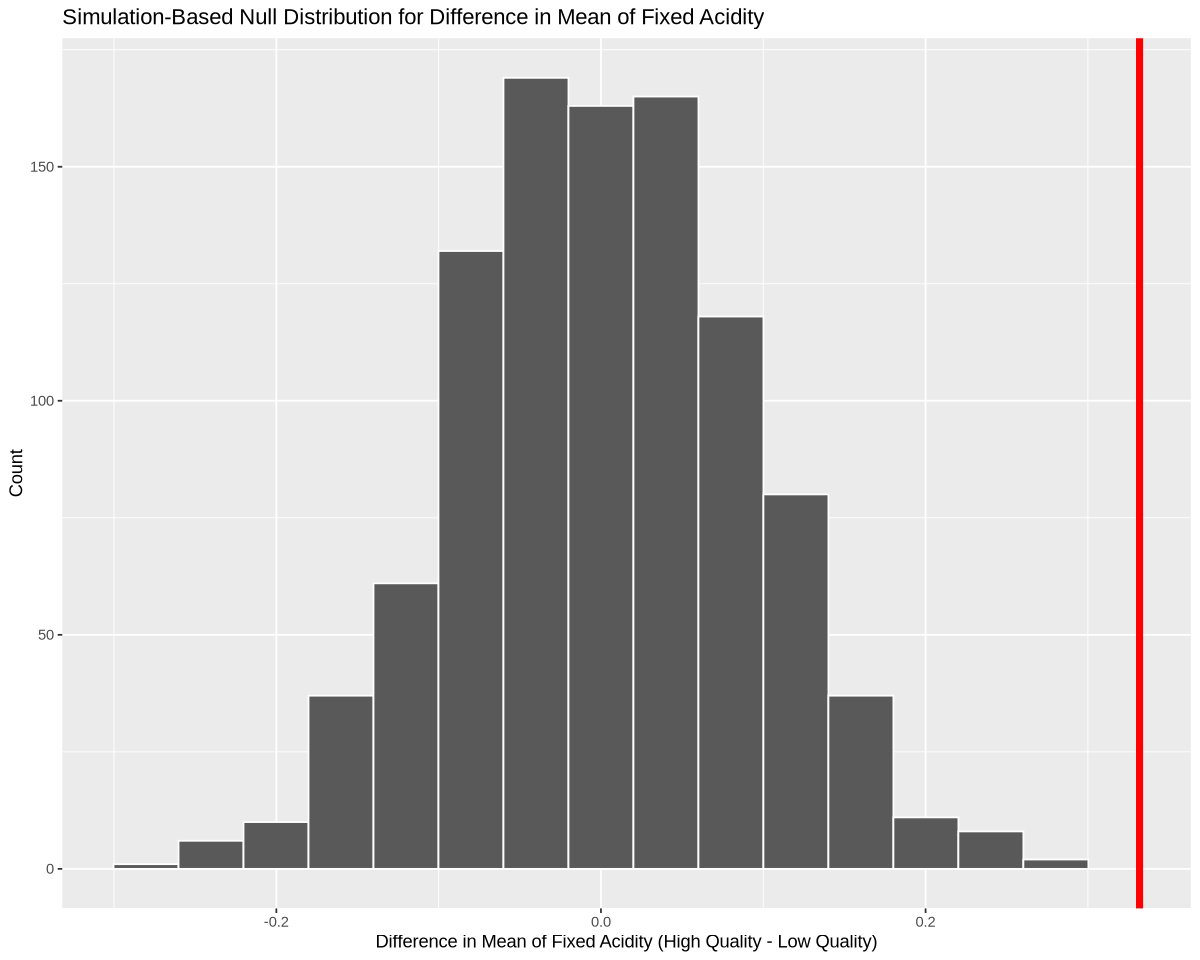

In [15]:
# Visualizing the observed mean difference of fixed acidity against the null distribution
options(repr.plot.width=10,repr.plot.height=8)
fixed_null_dist_plot <- fixed_null_dist |>
    visualize() +
    geom_vline(xintercept=obs_fixed_diff$stat[1], color="red", lwd = 2) +
    labs(x = "Difference in Mean of Fixed Acidity (High Quality - Low Quality)", 
         y = "Count", 
         title = "Simulation-Based Null Distribution for Difference in Mean of Fixed Acidity")
fixed_null_dist_plot

Figure 5: Histogram of the null distribution for mean differences of `fixed_acidity`. The red line is the mean difference of `fixed_acidity` observed from the original sample.

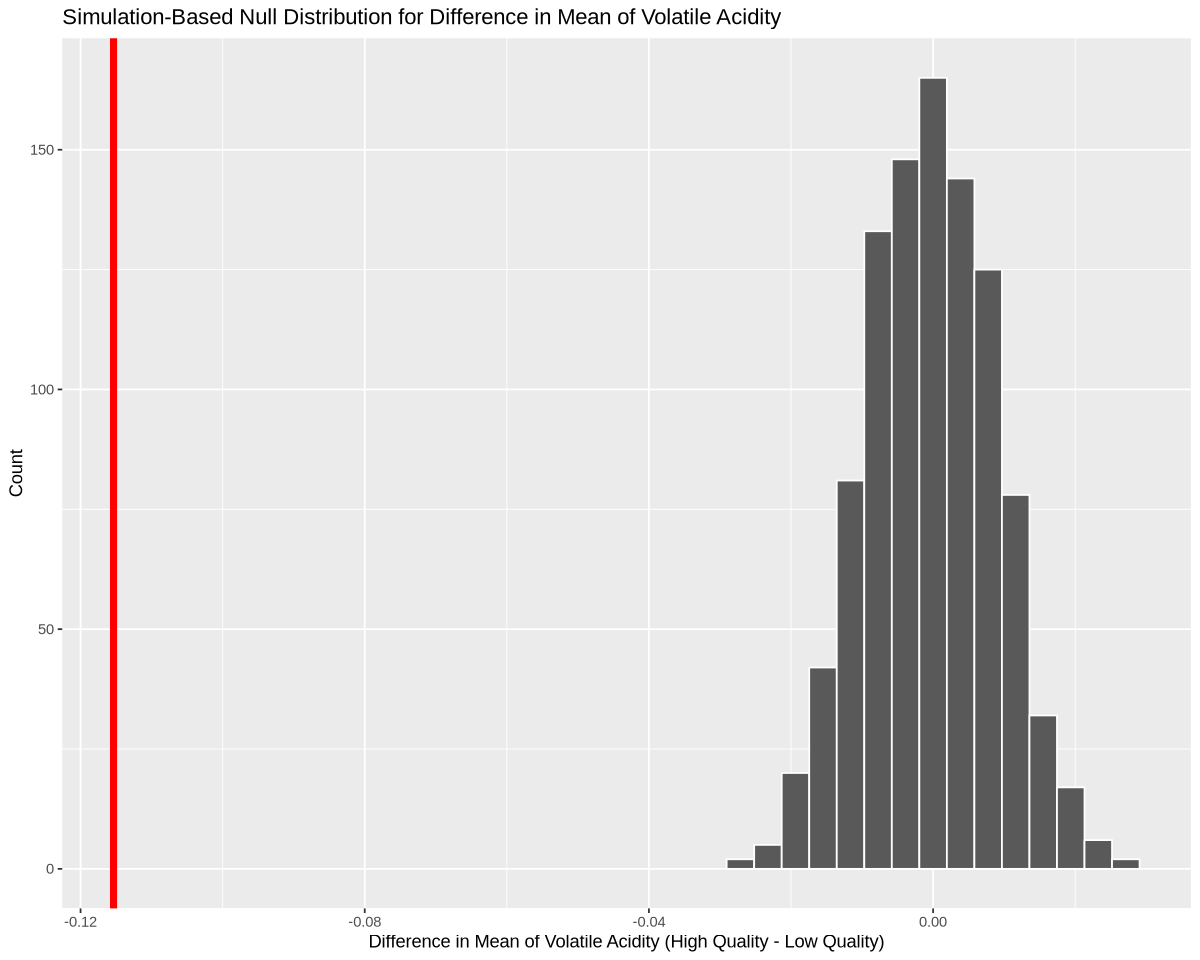

In [16]:
# Visualizing the observed mean difference of volatile acidity against the null distribution
options(repr.plot.width=10,repr.plot.height=8)
volatile_null_dist_plot <- volatile_null_dist |>
    visualize() +
    geom_vline(xintercept=obs_volatile_diff$stat[1], color="red", lwd = 2) +
    labs(x = "Difference in Mean of Volatile Acidity (High Quality - Low Quality)", 
         y = "Count", 
         title = "Simulation-Based Null Distribution for Difference in Mean of Volatile Acidity")
volatile_null_dist_plot

Figure 6: Histogram of the null distribution for mean differences of `volatile_acidity`. The red line is the mean difference of `volatile acidity` observed from the original sample.

As we can see from Figure 5, the mean difference of `fixed_acidity` that was observed from the original sample is highly unlikely to occur if the mean of `fixed_acidity` was the same for high quality and low quality wines.

Similarly, from Figure 6, the mean difference of `volatile_acidity` that was observed from the original sample is incredibly unlikely to occur if the mean of `volatile_acidity` was the same for high quality and low quality wines.

### Comparing Bootstrapping and Asymptotic Methods

The following table is a complete summary of our results.

In [17]:
# Combining the results from all bootstrapping and asymptotic methods
results <- bind_cols(bootstrap_ci, clt_ci[2], clt_ci[3], bootstrap_p_value[2], t_test_p_value[2])
results

Response,Bootstrap Lower CI,Bootstrap Upper CI,CLT Lower CI,CLT Upper CI,Bootstrap P-Value,t-Test P-Value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Fixed Acidity,0.1950176,0.4737029,0.1905108,0.4731508,<0.001,1.168400e-04
Volatile Acidity,-0.1286175,-0.1011156,-0.1294351,-0.1012779,<0.001,3.480735e-39


Table 8: Summary of the results obtained from bootstrapping and asymptotic (CLT and t-test) methods.

**Comparing Confidence Intervals**

Both the bootstrapping approach and the asymptotic approach produced very similar confidence intervals for both the mean difference of `fixed_acidity` and the mean difference of `volatile_acidity`. This makes sense, since both approaches are appropriate.
- The asymptotic approach is appropriate because the size of both samples (high and low quality wines) is sufficiently large, which means the Central Limit Theorem is applicable.
- The bootstrap approach is appropriate because the actual sample data is used to produce a bootstrap distribution for both the mean difference of `fixed_acidity` and the mean difference of `volatile_acidity`.

Realistically, either confidence interval can be reported given that both methods are appropriate and produce very similar confidence intervals.

**Comparing P-Values**

As with the confidence intervals, both the bootstrapping approach and the asymptotic approach are appropriate for hypothesis testing. 
- We have already shown that the asymptotic approach, namely the two-sample t-test, is appropriate for hypothesis testing on both the mean difference of `fixed_acidity` and the mean difference of `volatile_acidity` since both samples are sufficiently large.
- The bootstrapping approach is appropriate because the sample data is used to generate a null distribution for both the mean difference of `fixed_acidity` and the mean difference of `volatile_acidity`.

Unlike the confidence intervals, the bootstrapping approach and the asymptotic approach produced fairly different results. This is because for the bootstrapping approach, the precision of our obtained p-value is limited by the number of resamples we can take. 

The p-values obtained from performing two-sample t-tests, in particular the p-value for the mean difference in `volatile_acidity`, are very small—the number of resamples required for the bootstrapping approach to achieve the same level of precision far exceeds any reasonable amount of time and computational power. As a result, we cannot simply increase the number of resamples we take to achieve the same level of precision as the asymptotic approach. 

Therefore, the asymptotic approach is more trustworthy so we will elect to report the p-values from the two-sample t-tests. Using one approach for the hypothesis tests and a different approach for the confidence interval does not make much sense, and since both approaches produce trustworthy results, we will also report the results of the asymptotic approach for our confidence interval.

### Final Results

Fixed Acidity:
- We are 90% confident that the true mean difference of fixed acidity between high and low quality red wines is between 0.1905108 and 0.4731508 g(tartaric acid)/dm^3.
- We reject the null hypothesis at the 10% significance level and conclude that there is a difference in fixed acidity between high and low quality red wines.

Volatile Acidity:
- We are 90% confident that the true mean difference of fixed acidity between high and low quality red wines is between -0.1294351 and -0.1012779 g(acetic acid)/dm^3.
- We reject the null hypothesis at the 10% significance level and conclude that there is a difference in volatile acidity between high and low quality red wines.

## Discussion

The p-values obtained by asymptotics are 0.0001168400 for the mean difference in `fixed_acidity` and 3.480735e-39 for the mean difference in `volatile_acidity`. For both hypothesis tests, the p-value was less than the significance level of 0.1, so the null hypothesis was rejected both times. This means the original sample provides sufficient evidence to conclude that `fixed_acidity` and `volatile_acidity` differ between different qualities of red wine. This difference in acidity between good and poor quality red wines offers considerable value for determining red wine quality. Checking the acidity of red wine might help consumers pick the finest wine for their requirements. 

The two confidence intervals we obtained (via asymptotics) for the mean difference in `fixed_acidity` and the mean difference in `volatile_acidity` are (0.1905108, 0.4731508) and  (-0.1294351, -0.1012779) respectively. Fixed acidity is measured in g(tartaric acid)/dm^3 and volatile acidity is measured in g(acetic acid)/dm^3. We can see that the confidence interval for volatile acidity is negative, which means that low quality red wines have a greater amount of volatile acidity. This is corroborated by external research, as excessive volatile acidity in wine is known to lead to deterioration of said wine, resulting in a pungent flavour (Vilela-Moura et al., 2011). 

The extreme p-values, for the most part, validate our initial expectation that high and low quality red wines exhibit significant differences in acidity. This implies that acidity is indeed a critical element in determining a red wine's quality. In the future, we can investigate the chemical composition of acidity in greater detail to determine which components have the greatest impact on different qualities of red wine, or even if the effect of acidity on wine quality holds for other types of wine.

## References

- Ferrer, J., Huang, Z., Kiang, M., Moreno, I., Shaw, M., Wang, W., Asuncion, A., Bi, J., Bishop, C., Boser, B., Cherkassy, V., Cortez, P., Dietterich, T., Ebeler, S., &amp; Fao. (2009, June 9). Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems. https://www.sciencedirect.com/science/article/pii/S0167923609001377  
- UCI Machine Learning Repository: Wine Quality Data Set. (n.d.). UCI. https://archive.ics.uci.edu/ml/datasets/wine+quality
- Vilela-Moura, A., Schuller, D., Mendes-Faia, A., Silva, R. D., Chaves, S. R., Sousa, M. J., & Côrte-Real, M. (2011). impact of acetate metabolism on yeast fermentative performance and wine quality: Reduction of volatile acidity of grape musts and wines. Applied Microbiology and Biotechnology, 89(2), 271-280. https://doi.org/10.1007/s00253-010-2898-3
- White, N. A. (2019, March 18). Fixed acidity. Waterhouse Lab. https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity
- White, N. A. (2019, March 18). Volatile acidity. Waterhouse Lab. https://waterhouse.ucdavis.edu/whats-in-wine/volatile-acidity